## Overview

This document will demonstrate multiple approaches toward producing linear models in python using the US DoT airfare dataset.

Two Basic Linear Regression Models will are used:
* Numpy's `polyfit`

* Scipy Stats' `linregress`

Two Multiple Linear Regression Models are used:
* sklearn's `LinearRegression`

* statsmodels' `ols`

The most performant models in terms of adjusted R-squared often have some basic interaction terms applied that add useful complexity at the cost of a bit of interpretability.

#### Imports

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import sklearn.linear_model as lm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

## Data

Dataset:   airq402.dat

Source: U.S. Department of Transportation

Description: Airfares and passengers for U.S. Domestic Routes
for 4th Quarter of 2002.

Variables/Columns:
* `City1 (string)` - Origin (From) city

* `City2 (string)` - Destination (to) city

* `Average Fare` - average cost (in USD) Origin -> Destination across all airlines

* `Distance (int)` - distance (in miles) Origin -> Destination

* `Average weekly passengers` - average number of people flying Origin -> Destination per week

* `market leading airline (string)` - abbreviated name of airline with the largest % market share that offers Origin -> Destination flight

* `market share` - percentage of market that the leading airline possesses

* `Average fare` - average cost (in USD) that the leading airline charges for Origin -> Destination

* `Low price airline (string)` - abbreviated name of airline offering the lowest price for Origin -> Destination flight

* `market share` - percentage of market that the lowest price airline possesses

* `price` - actual price paid for this flight instance Origin -> Destination

Columns with unspecified data types are numeric floating point

Data may be obtained from:<br>
http://users.stat.ufl.edu/~winner/data/airq402.dat

Description provided by:<br>
http://users.stat.ufl.edu/~winner/data/airq402.txt

In [2]:
### Uncomment line to download dataset locally ###
#!wget http://users.stat.ufl.edu/~winner/data/airq402.dat

--2018-10-07 03:40:26--  http://users.stat.ufl.edu/~winner/data/airq402.dat
Resolving users.stat.ufl.edu (users.stat.ufl.edu)... 128.227.24.87
Connecting to users.stat.ufl.edu (users.stat.ufl.edu)|128.227.24.87|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77000 (75K) [text/plain]
Saving to: 'airq402.dat.1'

     0K .......... .......... .......... .......... .......... 66% 6.04M 0s
    50K .......... .......... .....                           100% 33.1M=0.009s

2018-10-07 03:40:27 (8.32 MB/s) - 'airq402.dat.1' saved [77000/77000]



In [2]:
# Assign new, compressed names to the columns 
colnames=['CityFrom','CityTo','AvgFare','Distance','AvgWeekPsgrs',
          'MktLeadArLn','MktShare','AvgFareLead','LowPriceArLn','MktShareLow','Price'] 

#airq = pd.read_fwf('airq402.dat', names=colnames)
airq = pd.read_fwf('http://users.stat.ufl.edu/~winner/data/airq402.dat', names=colnames)

In [3]:
airq.head()

,CityFrom,CityTo,AvgFare,Distance,AvgWeekPsgrs,MktLeadArLn,MktShare,AvgFareLead,LowPriceArLn,MktShareLow,Price
0,CAK,ATL,114.47,528,424.56,FL,70.19,111.03,FL,70.19,111.03
1,CAK,MCO,122.47,860,276.84,FL,75.10,123.09,DL,17.23,118.94
2,ALB,ATL,214.42,852,215.76,DL,78.89,223.98,CO,2.77,167.12
3,ALB,BWI,69.40,288,606.84,WN,96.97,68.86,WN,96.97,68.86
4,ALB,ORD,158.13,723,313.04,UA,39.79,161.36,WN,15.34,145.42


## Exploratory Data Analysis

The dataset has no missing values and 4 columns with object values, these could be treated as categorical, but they do have a high cardinality. Other than the handling of the object values, there is no preprocessing required, the data is clean enough for immediate analysis.

In [4]:
airq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
CityFrom        1000 non-null object
CityTo          1000 non-null object
AvgFare         1000 non-null float64
Distance        1000 non-null int64
AvgWeekPsgrs    1000 non-null float64
MktLeadArLn     1000 non-null object
MktShare        1000 non-null float64
AvgFareLead     1000 non-null float64
LowPriceArLn    1000 non-null object
MktShareLow     1000 non-null float64
Price           1000 non-null float64
dtypes: float64(6), int64(1), object(4)
memory usage: 86.0+ KB


In [5]:
airq.select_dtypes(include=['object']).nunique()

CityFrom        90
CityTo          85
MktLeadArLn     16
LowPriceArLn    19
dtype: int64

In [6]:
cats = ['CityFrom','CityTo','MktLeadArLn','LowPriceArLn']

In [7]:
city_stack = airq.CityFrom.append(airq.CityTo)
airln_stack = airq.MktLeadArLn.append(airq.LowPriceArLn)
print('unique locations: {} | unique airlines: {}'.format(city_stack.nunique(), airln_stack.nunique()))

unique locations: 104 | unique airlines: 19


Unsurprisingly, there is a good deal of overlap between the two city columns and two airline columns. With only 19 total airlines, the model would not be _too_ convoluted if we were to one-hot encode them. For locations, however, a cardinality of 104 would quickly clutter the model, and since one of the most attractive aspects of linear regression is its interpretability, this is likely a poor decision.

In [8]:
airq[cats] = airq[cats].astype('category')

What can be experimented with is a simple categorical encoding, wherein each unique entry is assigned it's own number. Pandas does with relative ease by assigning desired object columns to a `category` dtype.

In [9]:
airq.dtypes

CityFrom        category
CityTo          category
AvgFare          float64
Distance           int64
AvgWeekPsgrs     float64
MktLeadArLn     category
MktShare         float64
AvgFareLead      float64
LowPriceArLn    category
MktShareLow      float64
Price            float64
dtype: object

In [10]:
airq_enc = airq.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)

In order to actually use the numeric representation, we need to get the underlying `cat.codes` from pandas. Note the `.name` in the equivalence check, because of the way pandas handles categorical dtypes, simply comparing like one would with a float or int does not work.

In [11]:
airq_enc.dtypes

CityFrom           int8
CityTo             int8
AvgFare         float64
Distance          int64
AvgWeekPsgrs    float64
MktLeadArLn        int8
MktShare        float64
AvgFareLead     float64
LowPriceArLn       int8
MktShareLow     float64
Price           float64
dtype: object

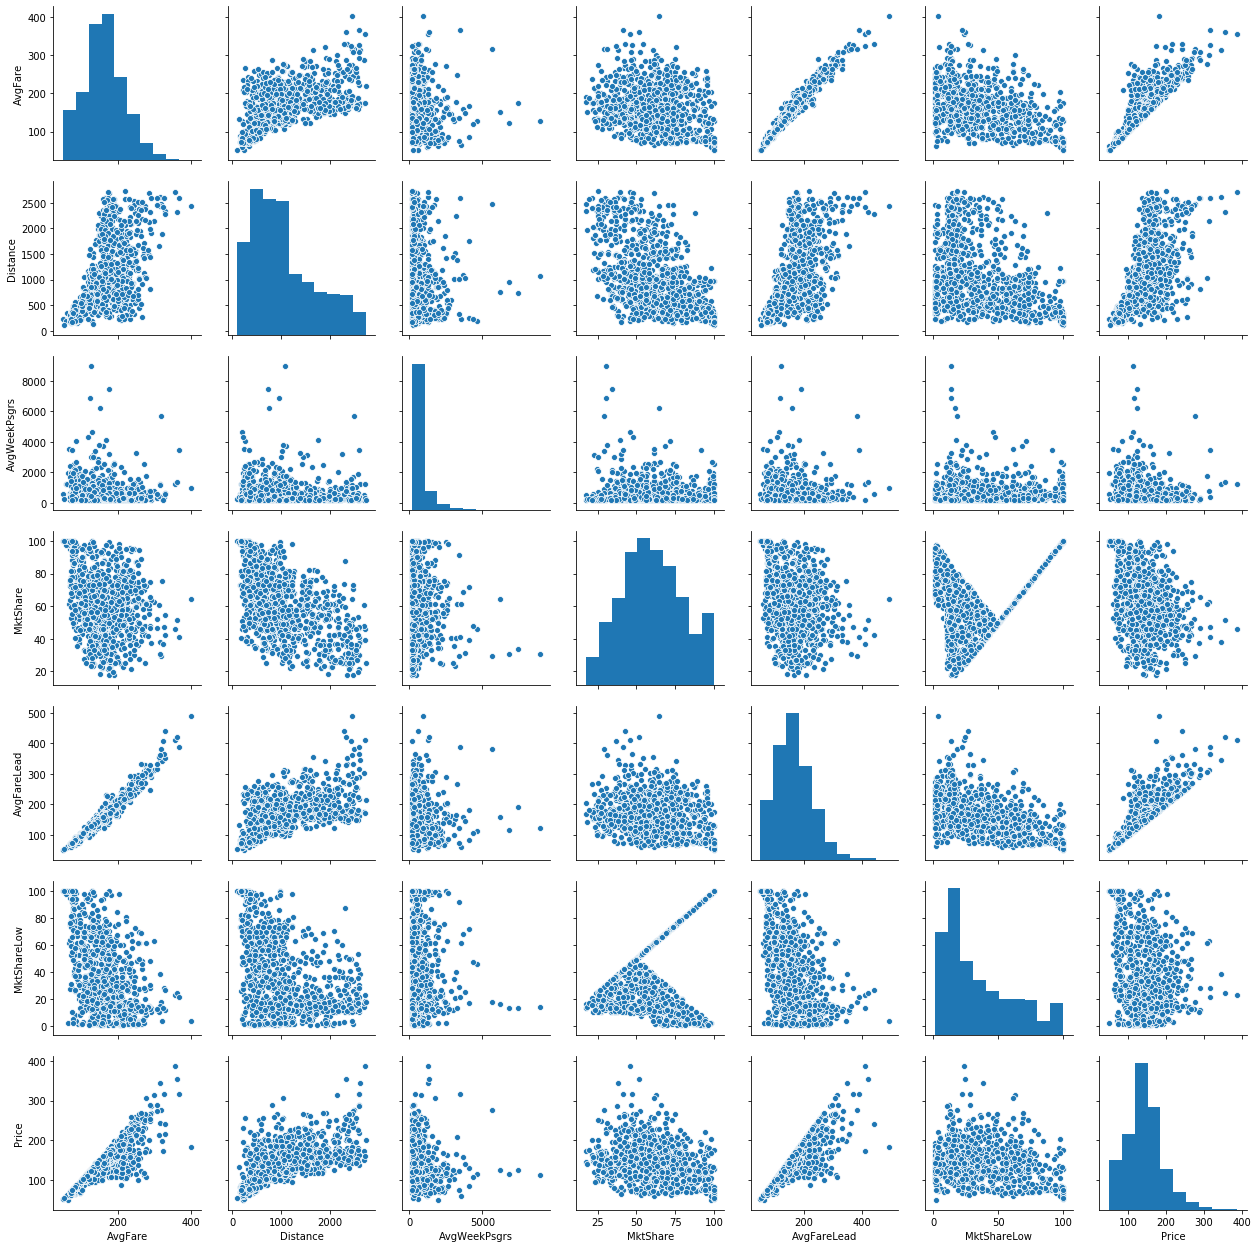

In [12]:
sns.pairplot(airq);

From these graphs, we can see very strong linear relationships among the `AvgFare`s and `Price`. This comes as no surprise as quite often, the leading airline controls such a large portion of the market share that they effectively set the price.

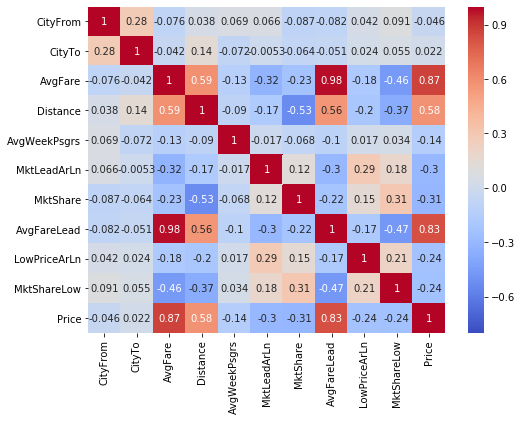

In [13]:
fig,ax = plt.subplots(figsize=(8,6))
sns.heatmap(airq_enc.corr(),vmin=-0.8, annot=True, cmap='coolwarm',ax=ax);

A correlation matrix provides a bit more evidence to the previous graphical analysis. We see that `AvgFareLead` and `AvgFare` are nearly perfectly correlated, and price is also strongly correlated with each of these variables.

## Models

2 Simple linear regression models are made with `numpy` and `scipy.stats` followed by 2 Multiple linear regressions models in `sklearn` and `StatModels`.

Using only 1 variable yielded an R-squared of ~0.75 for the basic models.

Using `sklearn's` an R-squared of ~0.816 is found.

Introducing interaction terms with StatModels' `ols` found the highest R-squared value at 0.900

In [14]:
# Define the model inputs
X, y = airq_enc.drop(columns=['Price']), airq_enc.Price
X_nc = X.drop(columns=X.select_dtypes('int8'))

#### Numpy's  LinReg

numpy's in-built least squares polynomial fit can be used with `deg=1` to mimic the most basic form of linear regression. We are given back just two things, the slope and intercept of the fit line.

In [15]:
np.polyfit(X.AvgFare, y, deg=1)

array([ 0.73908617, 22.44457608])

#### Scipy stats' LinReg

Scipy's `linregress` offers similar capabilities to that of numpy's `polyfit`, but returns a far richer representation of the model, also including the p-value, standard error and r value. 

In [16]:
ss.linregress(X.AvgFare,y)

LinregressResult(slope=0.7390861729620773, intercept=22.44457607612793, rvalue=0.8664103374911551, pvalue=2.8682051454337093e-303, stderr=0.013483299248515771)

Slope: 0.7390861729620773; Intercept: 22.44457607612793; R-squared: 0.751


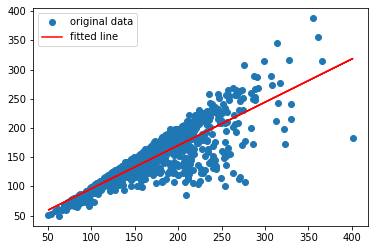

In [17]:
slope, intercept, r_value, p_value, std_err = ss.linregress(X.AvgFare,y)
print(f'Slope: {slope}; Intercept: {intercept}; R-squared: %0.3f' % r_value**2)
plt.plot(X.AvgFare,y, 'o', label='original data')
plt.plot(X.AvgFare, intercept + slope*X.AvgFare, 'r', label='fitted line')
plt.legend()
plt.show()

seaborn also has `lmplot` which serves as a much nicer way to handle plotting of a simple linear model. 

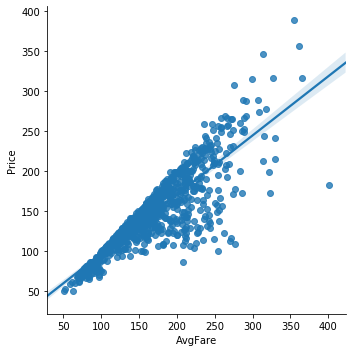

In [18]:
sns.lmplot('AvgFare','Price',airq);

#### Sklearn's linear regression

Moving up to the multi-linear regression models, sklearn's `LinearRegression` uses Ordinary Least Squares method with very little set up required, it's quick and effective. 

In [19]:
linreg = lm.LinearRegression()
model = linreg.fit(X,y)
print('R-squared: %0.5f' % model.score(X,y))

R-squared: 0.82447


In [20]:
print('R-squared: %0.5f' % lm.LinearRegression().fit(X_nc,y).score(X_nc,y))

R-squared: 0.81605


Using the data without any categorical values only slightly decreased the $R^2$ value, entirely excluding them from a model is an option worth considering.

#### StatsModels' linear regression

[StatsModels](http://www.statsmodels.org/stable/index.html) arguably provides the most feature rich, robust methods of linear regression. It supports two different syntaxes for modeling, a traditional pythonic approach and, for those accustomed to *R*, it has a formula based approach. Here, we will be using the latter as it is slightly more convenient.

In [21]:
rform = " + ".join(X.columns); rform # setup R-style RHS/X/exogenous variables

'CityFrom + CityTo + AvgFare + Distance + AvgWeekPsgrs + MktLeadArLn + MktShare + AvgFareLead + LowPriceArLn + MktShareLow'

In [22]:
resf = smf.ols(f'Price ~ {rform}', data=airq).fit()
rtab = resf.summary()

In [23]:
from IPython.display import display_html
display_html(rtab.tables[0], rtab.tables[2])
print(rtab.extra_txt)

Dep. Variable:,Price,R-squared:,0.866
Model:,OLS,Adj. R-squared:,0.830
Method:,Least Squares,F-statistic:,24.16
Date:,"Tue, 04 Jun 2019",Prob (F-statistic):,1.66e-241
Time:,10:20:20,Log-Likelihood:,-4268.0
No. Observations:,1000,AIC:,8960.
Df Residuals:,788,BIC:,1.000e+04
Df Model:,211,,
Covariance Type:,nonrobust,,


Omnibus:,107.169,Durbin-Watson:,2.161
Prob(Omnibus):,0.000,Jarque-Bera (JB):,492.914
Skew:,-0.384,Prob(JB):,9.23e-108
Kurtosis:,6.353,Cond. No.,2.25e+15


Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.04e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.


StatsModels resembles R's style very closely, meaning there is no need to pre-encode the categorical values as that is handled for us. Another nice feature that SM provides is warnings; a warning was displayed mentioning the possibility of strong multicollinearity.

Luckily, it also has a method for [calculating VIF](https://etav.github.io/python/vif_factor_python.html)

In [24]:
exv = resf.model.exog
exv_names = resf.model.exog_names
vifs = [vif(exv, i) for i in range(exv.shape[1])]

C:\Users\Rygu\Anaconda3\envs\i4061\lib\site-packages\statsmodels\stats\outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [25]:
vif_df = pd.DataFrame(data=[*zip(exv_names, vifs)],columns=['feature', 'VIF'])
vif_df[vif_df.VIF > 5].sort_values(by=['VIF'], ascending=False).head(10)

,feature,VIF
180,MktLeadArLn[T.G4],inf
197,LowPriceArLn[T.G4],inf
0,Intercept,603.358765
207,AvgFare,51.538090
211,AvgFareLead,46.067062
171,CityTo[T.TPA],21.581872
124,CityTo[T.LGA],20.834753
161,CityTo[T.SEA],20.661764
129,CityTo[T.MCO],19.607525
114,CityTo[T.IAD],18.924252


Looks like there are some very large issues with collinearity, this may indicate that allowing the default means of handling categorical variables doesn't quite work with cardinalities as high as they are.

In [26]:
resf.pvalues[resf.pvalues < 0.05].sort_values()

AvgFare               7.214757e-43
MktShareLow           6.069499e-33
MktShare              3.208881e-13
LowPriceArLn[T.TZ]    2.948838e-10
LowPriceArLn[T.WN]    1.641302e-07
AvgFareLead           1.849007e-06
LowPriceArLn[T.US]    1.127341e-05
LowPriceArLn[T.CO]    9.738363e-04
CityFrom[T.SFO]       2.546461e-03
LowPriceArLn[T.SY]    3.425680e-03
LowPriceArLn[T.NW]    5.234996e-03
LowPriceArLn[T.B6]    5.590586e-03
LowPriceArLn[T.DL]    1.319163e-02
LowPriceArLn[T.NK]    1.744641e-02
Intercept             2.125757e-02
CityTo[T.CVG]         2.463609e-02
CityFrom[T.MEM]       2.723465e-02
LowPriceArLn[T.UA]    2.786192e-02
MktLeadArLn[T.G4]     2.929860e-02
LowPriceArLn[T.G4]    2.929860e-02
CityFrom[T.DEN]       3.844163e-02
dtype: float64

Though `LowPriceArLn` and a handful of cities do fall within the realm of statistical significance, we add a large amount of unnecessary multicolinearity and clutter the model quite badly. So, lets try the model without any of the categorical variables and add in interaction terms.

In [27]:
rform_nc = '*'.join(X_nc.columns); rform_nc

'AvgFare*Distance*AvgWeekPsgrs*MktShare*AvgFareLead*MktShareLow'

Using `*` rather than `+` builds up interaction terms (`:`) for every variable, as well as including the original variables.

In [28]:
resf_nc = smf.ols(f"Price ~ {rform_nc}", data=airq).fit()
rtab_nc = resf_nc.summary()
display_html(rtab_nc.tables[0], rtab_nc.tables[2])
print(rtab_nc.extra_txt)

Dep. Variable:,Price,R-squared:,0.916
Model:,OLS,Adj. R-squared:,0.911
Method:,Least Squares,F-statistic:,171.2
Date:,"Tue, 04 Jun 2019",Prob (F-statistic):,0.00
Time:,10:20:26,Log-Likelihood:,-4033.6
No. Observations:,1000,AIC:,8189.
Df Residuals:,939,BIC:,8489.
Df Model:,60,,
Covariance Type:,nonrobust,,


Omnibus:,126.253,Durbin-Watson:,2.078
Prob(Omnibus):,0.000,Jarque-Bera (JB):,865.267
Skew:,-0.335,Prob(JB):,1.29e-188
Kurtosis:,7.507,Cond. No.,1.62e+16


Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.62e+16. This might indicate that there are
strong multicollinearity or other numerical problems.


After simply doing away with all non-numeric variables, we are left with an Adjusted $R^2$ of 0.911, a significant improvement over the previous, non-interacting model. We also can see that both the AIC and BIC scores have decreased, due to the reduction in model complexity.

In [29]:
Xsm = sm.add_constant(X_nc)
model_ols = sm.OLS(y, Xsm).fit()

C:\Users\Rygu\Anaconda3\envs\i4061\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [30]:
model_ols.pvalues.sort_values()

AvgFare         1.528071e-63
MktShareLow     6.450949e-42
MktShare        3.314792e-15
AvgFareLead     2.234886e-09
const           1.495716e-04
Distance        2.631488e-03
AvgWeekPsgrs    3.123756e-02
dtype: float64

## Conclusions

In this notebook several different means of doing linear regression in python were explored. 

Basic linear regression was done in `numpy` and `scipy.stats`, multiple linear regression was performed with `sklearn` and `StatsModels` 

After spending a large amount of time considering the best way to handle all the string values in the data, it turned out that the best was not to deal with them at all. Dropping any non-numeric values improved the model significantly.

There were many issues with collinearity across variables. Average Fare and Price are extremely closely related, which makes intuitive sense, considering Average Fare is just the mean price for that particular trip. 

#### Future work
Sklearn has many other learner models that were left unexplored, Lasso, Ridge, Huber, all potential candidates for further exploration. Additionally, there are many more transformation that could be tried on the data to fit a line better. Only interaction terms were tried between the `AvgFares` and `MktShares`, many other combinations could be attempted as well as polynomial transformations.

### References

#### Code & Docs
1. http://www.statsmodels.org/stable/index.html
2. https://etav.github.io/python/vif_factor_python.html
3. https://medium.freecodecamp.org/data-science-with-python-8-ways-to-do-linear-regression-and-measure-their-speed-b5577d75f8b
4. http://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html
5. https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html
6. https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.polyfit.html
7. http://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model

#### Text
1. http://users.stat.ufl.edu/~winner/data/airq402.txt

#### Other
1. https://en.wikipedia.org/wiki/Variance_inflation_factor